In [1]:
import sys
import os
current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)
from combiners import EpochsCombiner
from typing import *
import mne
import tensorflow as tf
import mneflow as mf
import matplotlib.pyplot as plt
import numpy as np
from utils.data_management import dict2str
from lfcnn_vis import plot_patterns
from LFCNN_decoder import SpatialParameters, TemporalParameters, ComponentsOrder, Predictions
import pickle
from utils.machine_learning import one_hot_decoder
import sklearn.metrics as sm
from utils.machine_learning.confusion import ConfusionEstimator
import scipy as sp
import itertools as it
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pandas as pd
from PIL import Image
from collections import namedtuple
import matplotlib.colors as mc

def read_pkl(path: str) -> Any:
    with open(
            path,
            'rb'
        ) as file:
        content = pickle.load(
            file
        )
    return content

2023-01-04 15:44:07.888498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-04 15:44:08.204780: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-04 15:44:08.204824: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-04 15:44:09.402497: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [89]:
root = '../Source/Subjects'
scores = 0
case = 'lm_vs_li'
i = 0
for subj_name in os.listdir(root):
    i += 1
    
    if subj_name == 'Pse_Udo':
        continue
    
    tf_path = os.path.join(root, subj_name, 'TF_planes', 'BB1-BB8', 'RespCor')
    tf_file = os.path.join(tf_path, f'{case}.pkl')
    scorer = read_pkl(tf_file)
    print(scorer.tf_scores.mean(0).max())
    scores += scorer.tf_scores.mean(0).max()
scores/i

0.6960897477187333
0.7250858165372503
0.69343843076526
0.847382132383333
0.7089745948538733
0.7634265758358783
0.8270903123585336
0.6895991021324355


0.661231856953922

In [2]:
import pandas as pd
from utils.console.colored import warn

class PredictionsParser(object):
    def __init__(
        self,
        y_true: Union[list[int], np.ndarray],
        y_pred: Union[list[int], np.ndarray],
        class_names: Optional[Union[str, list[str]]] = None
    ):
        
        y_true = self.__check_numpy(y_true)
        y_pred = self.__check_numpy(y_pred)
        
        if y_true.shape != y_pred.shape:
            raise ValueError('Predictions and actual values are inconsistent. Actual values shape: {y_true.shape}, predictions shape: {y_pred.shape}')
        
        if len(y_true.shape) != 1:
            y_true = one_hot_decoder(y_true)
            y_pred = one_hot_decoder(y_pred)
        
        self._y_true = y_true
        self._y_pred = y_pred
        
        self._accuracy = sm.accuracy_score(y_true, y_pred)
        
        classes_true = np.unique(self._y_true)
        classes_pred = np.unique(self._y_pred)
        
        if np.any(classes_true != classes_pred):
            warn(f'Warning: Classes are inconsistent.\n\tActual classes: {classes_true}\n\tPredicted classes: {classes_pred}.\nTake actual classes')
            
        del classes_pred
        
        self._classes = classes_true
        self._n_classes = len(classes_true)
        
        if class_names is not None:
            
            if isinstance(class_names, str):
                class_names = class_names.split(' ')
            
            if len(class_names) != self.n_classes:
                raise ValueError(f'Class names and classes are inconsistent: number of classes is {self.n_classes}, but {len(class_names)} names of classes were given')
        else:
            class_names = [f'Class {i}' for i in range(self.n_classes)]
        
        self._class_names = class_names
        
        self._confusion = pd.DataFrame(
            sm.confusion_matrix(self.y_true, self.y_pred),
            index = [f'Actual {class_name}' for class_name in self.class_names],
            columns = [f'Predicted {class_name}' for class_name in self.class_names]
        )
    
    @staticmethod
    def __check_numpy(arr: Union[list, tuple, np.ndarray]):
        if isinstance(arr, np.ndarray):
            return arr
        elif not isinstance(arr, np.ndarray) and isinstance(arr, (list, tuple)):
            return np.array(arr)
        else:
            raise ValueError(f'The given argument must be either a np.ndarray or a list, but {type(arr)} was given')
        
    @property
    def y_true(self):
        return self._y_true
    @y_true.setter
    def y_true(self, value):
        raise AttributeError('Impossible to set y_true directly')
    
    @property
    def y_pred(self):
        return self._y_pred
    @y_pred.setter
    def y_pred(self, value):
        raise AttributeError('Impossible to set y_pred directly')
    
    @property
    def accuracy(self):
        return self._accuracy
    @accuracy.setter
    def accuracy(self, value):
        raise AttributeError('Impossible to set accuracy directly')
    
    @property
    def classes(self):
        return self._classes
    @classes.setter
    def classes(self, value):
        raise AttributeError('Impossible to set classes directly')
    
    @property
    def n_classes(self):
        return self._n_classes
    @n_classes.setter
    def n_classes(self, value):
        raise AttributeError('Impossible to set number of classes directly')
    
    @property
    def class_names(self):
        return self._class_names
    @class_names.setter
    def class_names(self, value):
        raise AttributeError('Impossible to set names for classes directly')
    
    @property
    def confusion(self):
        return self._confusion
    @confusion.setter
    def confusion(self, value):
        raise AttributeError('Impossible to set confusion matrix directly')
    
    def summary(self, *args: str):
        df = self.confusion.copy()
        summary = pd.DataFrame(columns = self.class_names)
        summary.loc['Total'] = [df[column].sum() for column in df.columns]
        summary.loc['Accuracy'] = [None for _ in range(self.n_classes)]
        summary.loc['Specificity'] = [None for _ in range(self.n_classes)]
        summary.loc['Sensitivity'] = [None for _ in range(self.n_classes)]
        
        ec = self.estimate_confusion()
        
        args = list(args)
        for i, arg in enumerate(args):
            if not isinstance(arg, tuple):
                args[i] = arg, arg
        
        for arg_value, arg_name in args:
            if hasattr(ec[self.class_names[0]], arg_value):
                summary.loc[arg_name] = [None for _ in range(self.n_classes)]
            else:
                warn(f'WARNING: the {arg_value} property was not found in the confusion evaluator, so it was ignored')
                args.remove((arg_value, arg_name))
            
        
        for i, class_name in enumerate(self.class_names):
            summary[class_name].loc['Accuracy'] = ec[class_name].acc
            summary[class_name].loc['Specificity'] = ec[class_name].spec
            summary[class_name].loc['Sensitivity'] = ec[class_name].sens
            
            for arg_value, arg_name in args:
                summary[class_name].loc[arg_name] = getattr(ec[class_name], arg_value)
            
        return summary
    
    def estimate_confusion(self):
        
        return {
            class_name: ConfusionEstimator(
                # tp, tn, fp, fn
                self.confusion[self.confusion.columns[i]][self.confusion.index[i]],
                self.confusion[
                    list(self.confusion.columns[:i]) + list(self.confusion.columns[i+1:])
                    ].loc[
                        list(self.confusion.index[:i]) + list(self.confusion.index[i+1:])
                ].sum().sum(),
                self.confusion[self.confusion.columns[i]].loc[
                    list(self.confusion.index[:i]) + list(self.confusion.index[i+1:])
                ].sum(),
                self.confusion[
                    list(self.confusion.columns[:i]) + list(self.confusion.columns[i+1:])
                ].loc[self.confusion.index[i]].sum()
            )
            for i, class_name in enumerate(self.class_names)
        }



In [241]:

perf_tables_path = '../Source/perf_tables/'
from utils.storage_management import check_path
check_path(perf_tables_path)

for subject_name in os.listdir(f'../Source/Subjects/'):
    
    subject_perf_tables_path = os.path.join(perf_tables_path, subject_name)
    check_path(subject_perf_tables_path)

    path = f'../Source/Subjects/{subject_name}/LFCNN'

    classification_tables_path = os.path.join(subject_perf_tables_path)
    check_path(classification_tables_path)
    
    sumdf = pd.DataFrame()
    confdf = pd.DataFrame()
    for classification in [
        'RM_vs_RI_vs_LM_vs_LI',
        'RM_vs_RI',
        'LM_vs_LI',
        'RM&RI_vs_LM&LI'
    ]:
        file_name = f'{classification}_pred.pkl'
        class_names = classification.split('_vs_')

        try:
            predictions = read_pkl(
                os.path.join(path, 'Predictions', file_name)
            )
        except FileNotFoundError:
            warn(f'File does not exist: {os.path.join(path, "Predictions", file_name)}')
            continue
        pp = PredictionsParser(predictions.y_true, predictions.y_p, class_names)
        
        sumdf = pd.concat([
                sumdf,
                pp.summary(),
                pd.DataFrame([None for _ in range(pp.summary().shape[0])], index=pp.summary().index),
            ],
            axis=1
        )
        confdf = pd.concat([
                confdf,
                pp.confusion,
                # pd.DataFrame([None for _ in range(pp.confusion.shape[0])], index=pp.confusion.index),
                pd.DataFrame(list(confdf.index), index=confdf.index),
            ],
            axis=1
        )
    sumdf.to_excel(os.path.join(classification_tables_path, f'{subject_name}_{classification}_summary.xls'))
    confdf.to_excel(os.path.join(classification_tables_path, f'{subject_name}_{classification}_confusion.xls'))
    print(os.path.join(classification_tables_path, f'{subject_name}_{classification}_summary.xls'))

/tmp/ipykernel_28617/3937441739.py:50: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sumdf.to_excel(os.path.join(classification_tables_path, f'{subject_name}_{classification}_summary.xls'))
/tmp/ipykernel_28617/3937441739.py:51: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also

../Source/perf_tables/Pse_Udo/Pse_Udo_RM&RI_vs_LM&LI_summary.xls


/tmp/ipykernel_28617/3937441739.py:50: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sumdf.to_excel(os.path.join(classification_tables_path, f'{subject_name}_{classification}_summary.xls'))
/tmp/ipykernel_28617/3937441739.py:51: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also

../Source/perf_tables/Az_Mar/Az_Mar_RM&RI_vs_LM&LI_summary.xls


/tmp/ipykernel_28617/3937441739.py:50: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sumdf.to_excel(os.path.join(classification_tables_path, f'{subject_name}_{classification}_summary.xls'))
/tmp/ipykernel_28617/3937441739.py:51: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also

../Source/perf_tables/Fe_To/Fe_To_RM&RI_vs_LM&LI_summary.xls


/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:406: RuntimeWarning: divide by zero encountered in double_scalars
  self._lr_plus = self.tpr / self.fpr
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:408: RuntimeWarning: divide by zero encountered in double_scalars
  self._dor = self.lr_plus / self.lr_minus
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:406: RuntimeWarning: divide by zero encountered in double_scalars
  self._lr_plus = self.tpr / self.fpr
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:408: RuntimeWarning: divide by zero encountered in double_scalars
  self._dor = self.lr_plus / self.lr_minus
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:406: RuntimeWarning: divide by zero encountered in double_scalars
  self._lr_plus = self.tpr / self.fpr
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:40

../Source/perf_tables/Ga_Fed/Ga_Fed_RM&RI_vs_LM&LI_summary.xls


/tmp/ipykernel_28617/3937441739.py:50: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sumdf.to_excel(os.path.join(classification_tables_path, f'{subject_name}_{classification}_summary.xls'))
/tmp/ipykernel_28617/3937441739.py:51: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also

../Source/perf_tables/Ku_EL/Ku_EL_RM&RI_vs_LM&LI_summary.xls


/tmp/ipykernel_28617/3937441739.py:50: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sumdf.to_excel(os.path.join(classification_tables_path, f'{subject_name}_{classification}_summary.xls'))
/tmp/ipykernel_28617/3937441739.py:51: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also

../Source/perf_tables/Pr_An/Pr_An_RM&RI_vs_LM&LI_summary.xls


/tmp/ipykernel_28617/3937441739.py:50: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sumdf.to_excel(os.path.join(classification_tables_path, f'{subject_name}_{classification}_summary.xls'))
/tmp/ipykernel_28617/3937441739.py:51: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also

../Source/perf_tables/Ru_Ek/Ru_Ek_RM&RI_vs_LM&LI_summary.xls


/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:406: RuntimeWarning: divide by zero encountered in double_scalars
  self._lr_plus = self.tpr / self.fpr
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:408: RuntimeWarning: divide by zero encountered in double_scalars
  self._dor = self.lr_plus / self.lr_minus
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:406: RuntimeWarning: divide by zero encountered in double_scalars
  self._lr_plus = self.tpr / self.fpr
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:408: RuntimeWarning: divide by zero encountered in double_scalars
  self._dor = self.lr_plus / self.lr_minus
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:406: RuntimeWarning: divide by zero encountered in double_scalars
  self._lr_plus = self.tpr / self.fpr
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:40

../Source/perf_tables/Se_Tu/Se_Tu_RM&RI_vs_LM&LI_summary.xls
../Source/perf_tables/Te_Ali/Te_Ali_RM&RI_vs_LM&LI_summary.xls


/tmp/ipykernel_28617/3937441739.py:50: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sumdf.to_excel(os.path.join(classification_tables_path, f'{subject_name}_{classification}_summary.xls'))
/tmp/ipykernel_28617/3937441739.py:51: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also

In [4]:
from utils.storage_management import check_path
perf_tables_path = '../Source/perf_tables/LFCNN'
check_path(perf_tables_path)
from utils.storage_management import check_path
postfix = ''
group_tables_path = os.path.join(perf_tables_path, 'Group')
check_path(group_tables_path)
classification_tables_path = os.path.join(group_tables_path, postfix)
check_path(perf_tables_path, group_tables_path, classification_tables_path)

sumdf = pd.DataFrame()
confdf = pd.DataFrame()
for classification in [
        'RM_vs_RI_vs_LM_vs_LI',
        'RM_vs_RI',
        'LM_vs_LI',
        'RM&RI_vs_LM&LI'
    ]:
    conf = list()
    summary = list()
    for subject_name in os.listdir(f'../Source/Subjects/'):
        path = f'../Source/Subjects/{subject_name}/LFCNN'
        check_path(path)
        
        file_name = f'{classification}{postfix}_pred.pkl'
        class_names = classification.split('_vs_')

        try:
            predictions = read_pkl(
                os.path.join(path, 'Predictions', file_name)
            )
        except FileNotFoundError:
            warn(f'File does not exist: {os.path.join(path, "Predictions", file_name)}')
            continue
        pp = PredictionsParser(predictions.y_true, predictions.y_p, class_names)
        conf.append(pp.confusion)
        summary.append(pp.summary())
    
    index, columns = summary[0].index, summary[0].columns
    data = np.array([c.to_numpy() for c in summary]).mean(0)
    local_summary = pd.DataFrame(data, index=index, columns=columns)
    sumdf = pd.concat([
        sumdf,
        local_summary,
        pd.DataFrame([None for _ in range(local_summary.shape[0])], index=local_summary.index),
    ], axis=1)
    
    index, columns = conf[0].index, conf[0].columns
    data = np.array([s.to_numpy() for s in conf]).mean(0)
    local_conf = pd.DataFrame(data, index=index, columns=columns)
    confdf = pd.concat([
        confdf,
        local_conf,
        pd.DataFrame(list(local_conf.index), index=local_conf.index),
    ], axis=1)

sumdf.to_excel(
    os.path.join(classification_tables_path, f'group_{classification}_summary.xls')
)
confdf.to_excel(os.path.join(classification_tables_path, f'group_{classification}_confusion.xls'))

/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:406: RuntimeWarning: divide by zero encountered in double_scalars
  self._lr_plus = self.tpr / self.fpr
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:408: RuntimeWarning: divide by zero encountered in double_scalars
  self._dor = self.lr_plus / self.lr_minus
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:406: RuntimeWarning: divide by zero encountered in double_scalars
  self._lr_plus = self.tpr / self.fpr
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:408: RuntimeWarning: divide by zero encountered in double_scalars
  self._dor = self.lr_plus / self.lr_minus
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:406: RuntimeWarning: divide by zero encountered in double_scalars
  self._lr_plus = self.tpr / self.fpr
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:40

In [193]:



subjects_path = '../Source/Subjects/'
file_name = 'LM_vs_LI_vs_RM_vs_RI_B1-B8_pred.pkl'
# file_name = 'LM&LI_vs_RM&RI_B1-B8_pred.pkl'
class_names = file_name[:-15].split('_vs_')

for subject_name in os.listdir(subjects_path):
    
    if subject_name == 'Pse_Udo':
        continue
    
    subject_path = os.path.join(subjects_path, subject_name)

    predictions = read_pkl(
        os.path.join(subject_path, 'Predictions', file_name)
    )

    pp = PredictionsParser(predictions.y_true, predictions.y_p, class_names)
    print(subject_name)
    print(f'Total accuracy: {pp.accuracy : .2f}')
    summary = pp.summary()
    summary = summary.astype(float).round(2)
    print(summary)
    print(pp.confusion)
    print('-'*100)

Ga_Fed_06
Total accuracy:  0.55
                LM     LI     RM    RI
Total        16.00  12.00  16.00  9.00
Accuracy      0.77   0.77   0.77  0.77
Specificity   0.84   0.89   0.80  0.86
Sensitivity   0.62   0.50   0.67  0.33
           Predicted LM  Predicted LI  Predicted RM  Predicted RI
Actual LM            10             4             1             1
Actual LI             6             8             1             1
Actual RM             0             0             8             4
Actual RI             0             0             6             3
----------------------------------------------------------------------------------------------------
Fe_To_08
Total accuracy:  0.57
                LM     LI     RM    RI
Total        12.00  18.00  16.00  8.00
Accuracy      0.78   0.76   0.80  0.81
Specificity   0.92   0.78   0.81  0.93
Sensitivity   0.50   0.69   0.73  0.42
           Predicted LM  Predicted LI  Predicted RM  Predicted RI
Actual LM             9             7             

/tmp/ipykernel_19962/2523103007.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.any(classes_true != classes_pred):
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:255: RuntimeWarning: invalid value encountered in long_scalars
  self._ppv = self.tp / (self.tp + self.fp)
/home/user/Projects/FingerMovementDecoder/utils/machine_learning/confusion.py:263: RuntimeWarning: invalid value encountered in true_divide
  self._mcc = (self.tp * self.tn - self.fp * self.fn) / \


In [ ]:
subjects_path = '../Source/Subjects/'
# file_name = 'LM_vs_LI_vs_RM_vs_RI_B1-B8_pred.pkl'
# file_name = 'LM&LI_vs_RM&RI_B1-B8_pred.pkl'
file_name = 'LM_vs_LI_B1-B8_pred.pkl'
class_names = file_name[:-15].split('_vs_')

for subject_name in os.listdir(subjects_path):
    
    if subject_name == 'Pse_Udo':
        continue
    
    subject_path = os.path.join(subjects_path, subject_name)

    predictions = read_pkl(
        os.path.join(subject_path, 'Predictions', file_name),
    )

    y_t = one_hot_decoder(predictions.y_true)

    y_p = one_hot_decoder(predictions.y_p)

    print(subject_name)
    tn, fp, fn, tp = sm.confusion_matrix(y_t, y_p).ravel()
    ce = ConfusionEstimator(tp, tn, fp, fn)

    print(
        f'\tT\tF\n'\
        f'P\t{tp}\t{fp}\n'\
        f'N\t{tn}\t{fn}\n'
        f'Accuracy: {ce.acc}\n'\
        f'Specificity: {ce.spec}\n'\
        f'Sensitivity: {ce.sens}\n'
    )

In [7]:
# p-values for each subject and averages

from collections import namedtuple


DataContainer = namedtuple('DataContainer', 'data name title')

for kind in ['fullrange', 'before', 'after']:
    df_data = list()
    for classification, title in zip(
        [
            'RM_vs_RI_vs_LM_vs_LI',
            'RM&RI_vs_LM&LI',
            'LM_vs_LI',
            'RM_vs_RI'
        ], [
            '4 fingers',
            'Left vs Right',
            'Within Left',
            'Within Right'
        ]
    ):
        order = list(it.product(['B1-B3', 'B10-B12'], repeat=2))
        order[-1], order[-2] = order[-2], order[-1]
        all_data = list()
        for i, ((seq1, seq2), color) in enumerate(zip(order, ['blue', 'red', 'orange', 'green'])):
            path = f'/home/user/Downloads/Pics/perf_tables_{kind}/{classification}_train_{seq1}_test_{seq2}_sep.csv'
            df = pd.read_csv(path, index_col = 0)
            subjects = set(df.index)
            data = np.array([df.test_acc[f'{subject}'].to_numpy() for subject in subjects])
            all_data.append(DataContainer(data, f'{seq1} : {seq2}', title))

        data1, data2 = all_data[:2], all_data[2:]
        for data in [data1, data2]:
            name = f'{data[0].title} | {data[0].name} | {data[1].name}'
            stat, pvals = sp.stats.ttest_rel(data[0].data, data[1].data, axis=1)
            sdata = {
                subject: p
                for subject, p in zip(subjects, pvals)
            }
            stat, pval = sp.stats.ttest_rel(data[0].data.mean(1), data[1].data.mean(1))
            sdata['Average'] = pval
            df_data.append(pd.Series(sdata, name=name))
    df = pd.DataFrame(df_data).T
    df.to_excel(f'/home/user/Downloads/Pics/{kind}_output.xlsx')

In [ ]:
# violinplot for each classification accuracy to subject x sessions

span = 1
%matplotlib qt
plt.rcParams.update({'font.size': 22})

def adjust_fig(fig):
    fig['cmeans'].set_color('red')
    fig['cbars'].set_edgecolor('gray')
    fig['cbars'].set_alpha(.5)
    fig['cbars'].set_linewidth(.8)
    fig['cmaxes'].set_color('#042164')
    fig['cmins'].set_color('#042164')
    fig['cquantiles'].set_color('#EE550E')

def plot_stars(n_subject, n_cap, n_stars, star_symbol='*'):
    #? These numbers (9 and 4) are n_subjects & average, n_sessions
    indices = [i for i in range(45) if (i+1)%5]
    indices = np.reshape(indices, (9, 4))[:, 1:3]
    index = indices[n_subject, n_cap]

    # The numbers are hand-picked
    if (n_cap+1)%2:
        height = 1.08
    else:
        height = 1.19

    if n_stars%2:
        distances = [np.round((i-n_stars//2)*.4, 2) for i in range(n_stars)]
    else:
        distances = list(map(
            lambda x: x[1] if x[0] >= n_stars//2 else -x[1],
            enumerate(map(
                lambda x: np.round(x*.4, 2) if x != 0 else .2,
                [i for i in range(n_stars//2)][::-1] + list(range(n_stars//2))
            ))
        ))

    for distance in distances:
        plt.plot(index+distance, height, star_symbol, c='#1f77b4')

# cross = plt.scatter([], [], 120, color='#1f77b4', marker='x', label='p ≥ 0.05')
# star = plt.scatter([], [], 120, c='#1f77b4', marker='*', label='p < 0.05')
# star2 = mlines.Line2D([], [], color='#1f77b4', marker='*', linestyle='None',
#                          markersize=10, label='p < 0.01')

for kind in ['before', 'fullrange', 'after']:
    excel_file = f'/home/user/Downloads/Pics/{kind}_output.xlsx'
    stat = pd.read_excel(excel_file, index_col=0)
    # Simplified columns names to original ones
    col_info = {
        key: val
        for key, val
        in zip(
            [tuple([
                word.split(' : ')[0] for word in col.split(' | ')
            ][:2]) for col in stat.columns],
            stat.columns
        )
    }

    for classification, title in zip(
        [
            'RM_vs_RI_vs_LM_vs_LI',
            'RM&RI_vs_LM&LI',
            'LM_vs_LI',
            'RM_vs_RI'
        ], [
            '4 classes',
            'Left vs Right',
            'Within Left',
            'Within Right'
        ]
    ):
        # Limits to make a legend visible
        #! When these limits are changed, all hand-picked values are changed
        plt.ylim((0., 1.5))
        plt.yticks(
            [i/10 if i != 0 else 0 for i in range(0, 11, 2)],
        )
        plt.grid(True, axis='x', linewidth=100, alpha=.1)

        # Iterate all sessions
        order = list(it.product(['B1-B3', 'B10-B12'], repeat=2))
        order[-1], order[-2] = order[-2], order[-1]

        for i, ((seq1, seq2), color) in enumerate(zip(order, ['blue', 'red', 'orange', 'green'])):
            if i%2:
                # As tests are paired, only half of iterations is needed
                stat_data = stat[col_info[(title, seq1)]]

                for j, subject in enumerate(subjects):
                    k = 0 if seq1 == 'B1-B3' else 1
                    # print(title, subject, seq1, stat_data[subject], end=' ')

                    if stat_data[subject] >= 0.05:
                        plot_stars(j, k, 1, 'x')
                        # print(f'plotting x at {k}')
                    elif .01 <= stat_data[subject] < .05:
                        plot_stars(j, k, 1)
                        # print(f'plotting * at {k}')
                    elif .001 <= stat_data[subject] < .01:
                        plot_stars(j, k, 2)
                        # print(f'plotting ** at {k}')
                    elif stat_data[subject] < .001:
                        plot_stars(j, k, 3)
                        # print(f'plotting *** at {k}')

            path = f'/home/user/Downloads/Pics/perf_tables_{kind}/{classification}_train_{seq1}_test_{seq2}_sep.csv'
            df = pd.read_csv(path, index_col = 0)
            subjects = set(df.index)
            data = np.array([df.test_acc[f'{subject}'].to_numpy() for subject in subjects])
            data = np.append(data, [data.mean(0)], axis = 0)
            subjects = list(subjects) + ['Average']
            # all indices of current session for all subjects
            # without spaces between violenplots of different subjects
            plane = np.array([i for i in range(len(subjects)*4) if not (i)%4])
            fig = plt.violinplot(
                data.T, plane + i + np.array(range(len(plane)))*span,
                showmeans=True,
                quantiles = [[0.25, 0.75] for _ in subjects]
            )

            # Set color in concordance with session
            for i in range(len(subjects)):
                fig['bodies'][i].set_facecolor(color)

            adjust_fig(fig)

        _ = plt.xticks(
            plane + 1.5 + np.array(range(len(plane)))*span,
            subjects,
            rotation=30
        )

        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        b = mpatches.Patch(color='blue', label='B1-B3 | B1-B3', alpha=.4)
        r = mpatches.Patch(color='red', label='B1-B3 | B10-B12', alpha=.4)
        o = mpatches.Patch(color='orange', label='B10-B12 | B10-B12', alpha=.4)
        g = mpatches.Patch(color='green', label='B10-B12 | B1-B3', alpha=.4)
        s = mpatches.Patch(color='#1f77b4', label='', alpha=0)
        plt.legend(handles=[
            b, r, o, g#, cross, star, star2
        ], handlelength=1.25, numpoints=2, scatterpoints=1, loc='upper right', ncol=2)
        plt.title(title)

        # The numbers are hand-picked
        start = .051
        gap = .0209

        for i in range(9):
            #! the indexes were selected manually, correspond to the lines that require correction
            if i in [1, 3, 5, 7, 8]:
                plt.axhline(1.168, start + (5*i+1)*gap, start + (5*i+3)*gap-5e-4, linewidth=.5)
                plt.axhline(1.055, start + 5*i*gap, start + (5*i+2)*gap-5e-4, linewidth=.5)
            else:
                plt.axhline(1.168, start + (5*i+1)*gap, start + (5*i+3)*gap, linewidth=.5)
                plt.axhline(1.055, start + 5*i*gap, start + (5*i+2)*gap, linewidth=.5)

        pair1, pair2 = True, False
        # draw vertical lines
        for i in range(5*9):
            if (i+1)%5:
                if pair1:
                    pair1 = False
                    pair2 = True
                    plt.axvline(i, 0.678, .703, ls='--', linewidth=.75)
                    continue
                if pair2:
                    pair2 = False
                    pair1 = True
                    plt.axvline(i, 0.753, .778, ls='--', linewidth=.75)

        # plt.show()
        plt.savefig(f'/home/user/Downloads/Pics/{kind}/{classification}.jpg', dpi=500)
        plt.close()

    images = [
        Image.open(f'/home/user/Downloads/Pics/{kind}/' + f)
        for f in os.listdir(f'/home/user/Downloads/Pics/{kind}')
    ]
    pdf_path = f'/home/user/Downloads/Pics/{kind}_output.pdf'
    images[0].save(
        pdf_path, "PDF", resolution=100.0, save_all=True, append_images=images[1:]
    )


## Boxplot with stars

In [13]:

# boxplots classification x sessions to average accuracy
%matplotlib inline

plt.rcParams.update({'font.size': 22})
DataContainer = namedtuple('DataContainer', 'data name title')


def rename_sessions(sessions):
    out = list()
    for session in sessions:
        if session == 'B1-B3':
            out.append('beginning')
        elif session == 'B10-B12':
            out.append('end')
        else:
            raise ValueError(f'Unknown session: {session}')
    return ' : '.join(out)


def plot_stars(n_box, n_stars, star_symbol='*', height=1.125):

    if n_stars%2:
        distances = [np.round((i-n_stars//2)*.4, 2) for i in range(n_stars)]
    else:
        distances = list(map(
            lambda x: x[1] if x[0] >= n_stars//2 else -x[1],
            enumerate(map(
                lambda x: np.round(.2 + x*.4, 2) if x != 0 else .2,
                [i for i in range(n_stars//2)][::-1] + list(range(n_stars//2))
            ))
        ))

    n_box -= .5

    for distance in distances:
        plt.plot(n_box+distance, height, star_symbol, c='#1f77b4', ms=10)

ymin, ymax = .35, 1.35
diff=.35

order = list(it.product(['B1-B3', 'B10-B12'], repeat=2))
order[-1], order[-2] = order[-2], order[-1]

for kind in [
    # 'before',
    'fullrange',
    # 'after'
]:
    excel_file = f'/home/user/Downloads/Pics/{kind}_output.xlsx'
    stat = pd.read_excel(excel_file, index_col=0)
    col_info = {
        key: val
        for key, val
        in zip(
            [tuple([
                word.split(' : ')[0] for word in col.split(' | ')
            ][:2]) for col in stat.columns],
            stat.columns
        )
    }
    all_data = list()
    all_titles = list()
    all_stats = list()
    for classification, title in zip(
        [
            'RM_vs_RI_vs_LM_vs_LI',
            'RM&RI_vs_LM&LI',
            'LM_vs_LI',
            'RM_vs_RI'
        ], [
            '4 classes',
            'Left vs Right',
            'Within Left',
            'Within Right'
        ]
    ):
        for i, ((seq1, seq2), color) in enumerate(zip(order, ['blue', 'red', 'orange', 'green'])):
            if i%2:
                all_stats.append(stat[col_info[(title, seq1)]]['Average'])
            path = f'/home/user/Downloads/Pics/perf_tables_{kind}/{classification}_train_{seq1}_test_{seq2}_sep.csv'
            df = pd.read_csv(path, index_col = 0)
            data = [df['test_acc'][subject].mean() for subject in set(df['test_acc'].index)]
            all_data.append(data)
            all_titles.append(title)

    names = list(map(
        rename_sessions,
        order
    ))
    indices = [i for i in range(len(all_data) + len(all_data)//5) if (i+1)%5]
    for i, data in enumerate(all_data):
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
        iqr = q3 - q1
        p1 = min(
            filter(
                lambda datum: q1-1.5*iqr <= datum <= q1,
                data
            )
        )
        p2 = max(
            filter(
                lambda datum: q3 <= datum <= q3+1.5*iqr,
                data
            )
        )
        # .4 is min ylim
        plt.axvline(indices[i], p2-diff+.05, 1.1-diff, linewidth=1, color='#aaa')

        if i%2:
            if all_stats[i//2] >= .05:
                plot_stars(indices[i], 1, 'x')
            if .01 <= all_stats[i//2] < .05:
                plot_stars(indices[i], 1, '*')
            if .001 <= all_stats[i//2] < .01:
                plot_stars(indices[i], 2, '*')
            if all_stats[i//2] < .001:
                plot_stars(indices[i], 3, '*')

            plt.axhline(1.1, indices[i]*0.05, (indices[i]+1)*0.05, linewidth=1, color='#aaa')

    boxplot = plt.boxplot(all_data, positions=indices, showfliers=False, patch_artist=True)
    color = '#aaa'
    width = 1

    colorconfig = {
        session: color
        for session, color in zip(
            names,
            [mc.to_rgba('blue', .25), mc.to_rgba('red', .25), mc.to_rgba('yellow', .25), mc.to_rgba('green', .25)]
        )
    }

    for i, box in enumerate(boxplot['boxes']):
        box.set_facecolor(colorconfig[names[i%len(names)]])
        box.set_linewidth(0)
    for box in boxplot['caps']:
        box.set_color(color)
        box.set_linewidth(width*1.5)
    for box in boxplot['whiskers']:
        box.set_color(color)
        box.set_linewidth(width)
        box.set_linestyle('--')
    for box in boxplot['medians']:
        box.set_color('#FF1E0F')
        box.set_linewidth(width*1.25)
        box.set_alpha(.75)

    middles = [index-1.5 for i, index in enumerate(indices) if not (i+1)%4]
    _ = plt.xticks(
        middles,
        [title for i, title in enumerate(all_titles) if not (i+1)%4],
        rotation=30
    )
    _ = plt.yticks([.4, .6, .8, 1.])

    for i in middles:
        plt.axvline(i, 0, 1, c='gray', alpha=.1, linewidth=200)

    plt.xlim(-1, indices[-1]+1)
    plt.ylim(ymin, ymax)

    # b = mpatches.Patch(facecolor=mc.to_rgba('blue', .4), label='B1-B3 | B1-B3', edgecolor=mc.to_rgba('blue', .6))
    # r = mpatches.Patch(facecolor=mc.to_rgba('red', .4), label='B1-B3 | B10-B12', edgecolor=mc.to_rgba('red', .6))
    # o = mpatches.Patch(facecolor=mc.to_rgba('yellow', .4), label='B10-B12 | B10-B12', edgecolor=mc.to_rgba('#cccc00', .6))
    # g = mpatches.Patch(facecolor=mc.to_rgba('green', .4), label='B10-B12 | B1-B3', edgecolor=mc.to_rgba('green', .6))
    b = mpatches.Patch(facecolor=mc.to_rgba('blue', .4), label='Learning | Learning', edgecolor=mc.to_rgba('blue', .6))
    r = mpatches.Patch(facecolor=mc.to_rgba('red', .4), label='Learning | Learned', edgecolor=mc.to_rgba('red', .6))
    o = mpatches.Patch(facecolor=mc.to_rgba('yellow', .4), label='Learned | Learned', edgecolor=mc.to_rgba('#cccc00', .6))
    g = mpatches.Patch(facecolor=mc.to_rgba('green', .4), label='Learned | Learning', edgecolor=mc.to_rgba('green', .6))

    plt.legend(handles=[b, r, o, g], ncol=2, loc='upper right')
    fig = plt.gcf()
    # fig.set_size_inches(18.5, 10.5)
    fig.set_size_inches(18.5, 15.5)
    plt.xlabel('Task')
    plt.ylabel('Accuracy')
    # plt.show()
    plt.savefig(f'/home/user/Downloads/Pics/{kind}_boxplot.jpg', dpi=500)
    plt.close()


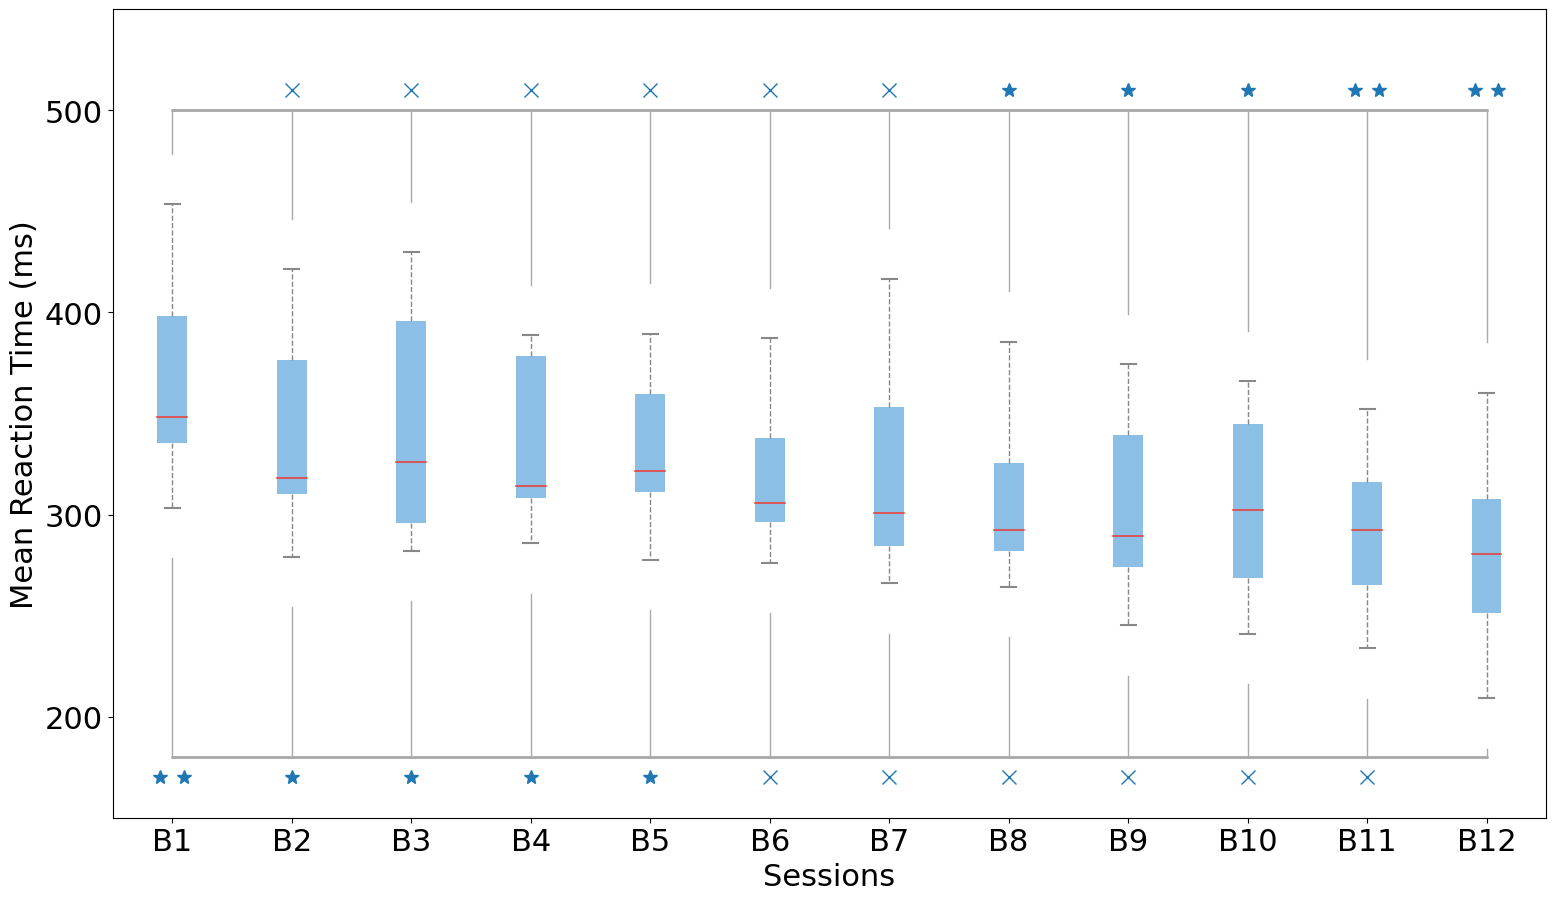

In [22]:
import pandas as pd

plt.rcParams.update({'font.size': 22})

def plot_stars(n_box, n_stars, star_symbol='*', height=1.125):
    if n_stars%2:
        distances = [np.round((i-n_stars//2)*.4, 2) for i in range(n_stars)]
    else:
        distances = list(map(
            lambda x: x[1] if x[0] >= n_stars//2 else -x[1],
            enumerate(map(
                lambda x: np.round(.2 + x*.4, 2) if x != 0 else .2,
                [i for i in range(n_stars//2)][::-1] + list(range(n_stars//2))
            ))
        ))

    # n_box -= .5

    for distance in distances:
        plt.plot(n_box+distance, height, star_symbol, c='#1f77b4', ms=10)

width = 1
# path = '/home/user/Downloads/sdata/MEG_SRTT_RT.xlsx'
path = '../Source/perf_data/MEG_SRTT_RT.xlsx'
df = pd.read_excel(path, index_col=1)
for index in df.columns:
    if not isinstance(index, (int, float)) or index > 12:
        df.drop(index, axis=1, inplace=True)
indices = [i for i in range(2*len(df.columns)) if (i+1)%2]
boxplot = plt.boxplot(df, patch_artist=True, positions=indices, showfliers=False)
color = '#888'

for i, box in enumerate(boxplot['boxes']):
    box.set_facecolor('#66aadd')
    box.set_alpha(.75)
    box.set_linewidth(0)
for box in boxplot['caps']:
    box.set_color(color)
    box.set_linewidth(width*1.5)
for box in boxplot['whiskers']:
    box.set_color(color)
    box.set_linewidth(width)
    box.set_linestyle('--')
for box in boxplot['medians']:
    box.set_color('#FF1E0F')
    box.set_linewidth(width*1.25)
    box.set_alpha(.75)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
xmin = -1
xmax = 2*len(df.columns)-1
plt.xlim([xmin, xmax])
get_x = lambda x: (x - xmin)/(xmax - xmin)
ymin = 150
ymax = 550
plt.ylim([ymin, ymax])
get_y = lambda y: (y - ymin)/(ymax - ymin)

for i, drange in zip([1, 12], [range(12), list(range(12))[::-1]]):
    if i == 1:
        height = 510
    if i == 12:
        height = 170
    for j in drange:
        if j+1 == i:
            continue
        s, p = sp.stats.ttest_ind(df[i], df[j+1])
        if p >= .05:
            plot_stars(indices[j], 1, star_symbol='x', height=height)
        elif .01 <= p < .05:
            plot_stars(indices[j], 1, height=height)
        elif .001 <= p < .01:
            plot_stars(indices[j], 2, height=height)
        elif p < .001:
            plot_stars(indices[j], 3, height=height)

for i, data in enumerate(df.to_numpy().T):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    p1 = min(
        filter(
            lambda datum: q1-1.5*iqr <= datum <= q1,
            data
        )
    )
    p2 = max(
        filter(
            lambda datum: q3 <= datum <= q3+1.5*iqr,
            data
        )
    )
    # .4 is min ylim
    plt.axvline(indices[i], get_y(p2+25), get_y(500), linewidth=1, color='#aaa')
    plt.axvline(indices[i], get_y(p1-25), get_y(180), linewidth=1, color='#aaa')
    plt.axhline(500, get_x(indices[0]), get_x(indices[-1]), linewidth=1, color='#aaa')
    plt.axhline(180, get_x(indices[0]), get_x(indices[-1]), linewidth=1, color='#aaa')

plt.xlabel('Sessions')
# plt.text(2, y=75, s='Stimulus\nOriented\nBlocks', ha='center')
# plt.text(2+9, y=92.15, s='Learning Blocks')
# plt.axhline(150, 0, 1, c=color)
plt.ylabel('Mean Reaction Time (ms)')
_ = plt.xticks([i-1 for i in range(2*len(df.columns)) if i%2], [f'B{int(i)}' for i in df.columns])
_ = plt.yticks([200, 300, 400, 500])
# ax2 = plt.axes([0,0,2,2], facecolor=(1,1,1,0))
plt.savefig('/home/user/Downloads/Pics/reaction_time.jpg', dpi=500)
# plt.close()
plt.show()


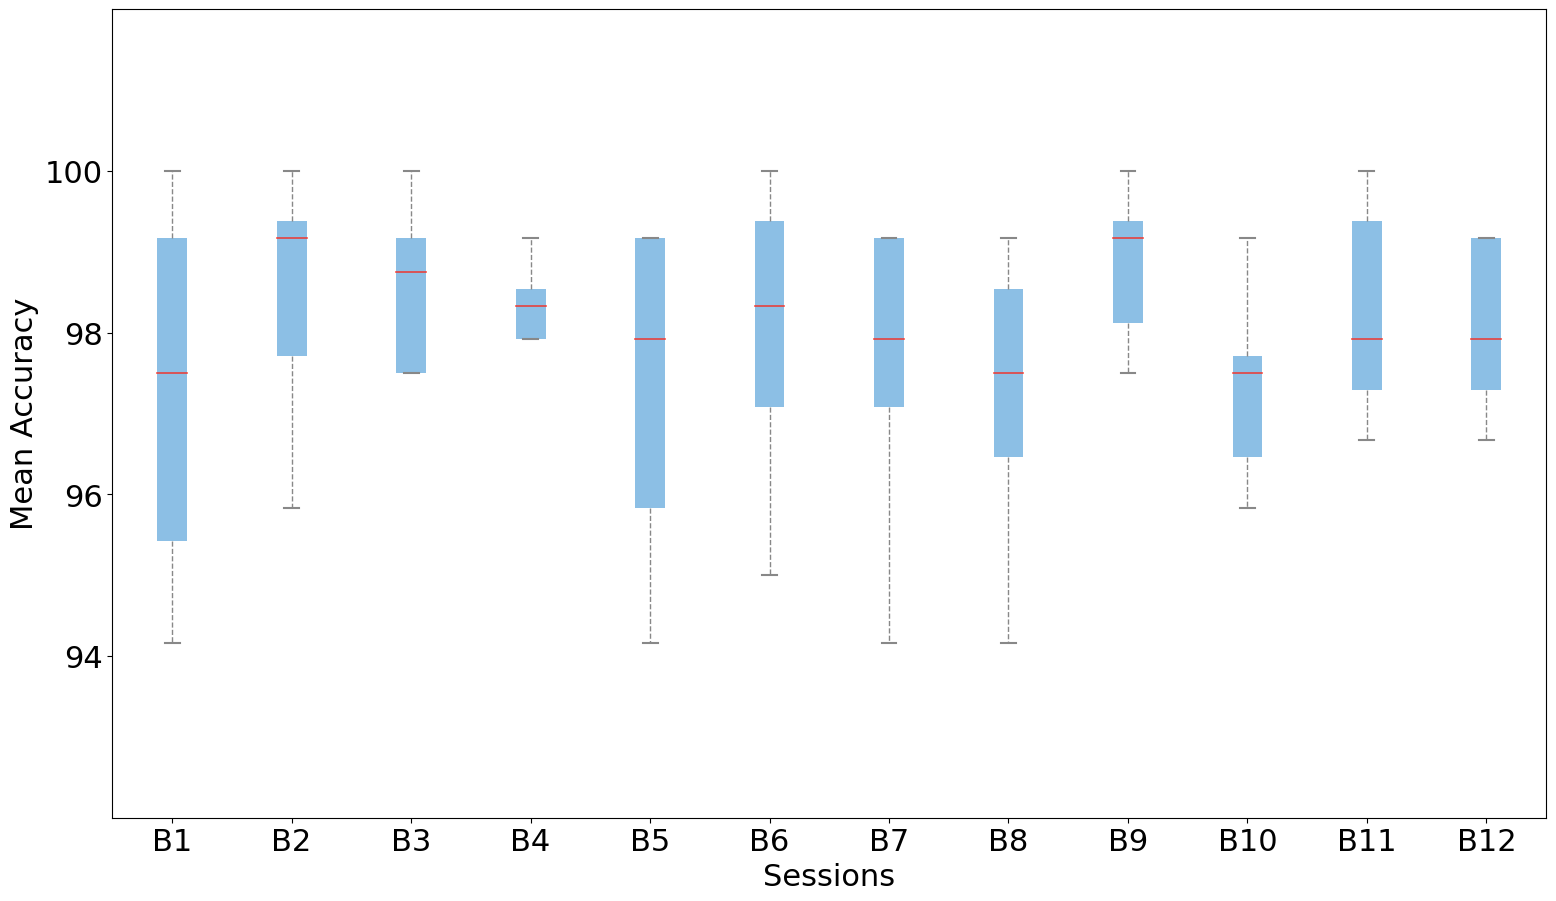

In [23]:
# path = '/home/user/Downloads/sdata/MEG_SRTT_ACC.csv'
path = '../Source/perf_data/MEG_SRTT_ACC.csv'
df = pd.read_csv(path, index_col=1)
for index in df.columns:
    if not str.isdigit(index) or int(index) > 12:
        df.drop(index, axis=1, inplace=True)
indices = [i for i in range(2*len(df.columns)) if (i+1)%2]
df = df.dropna()
boxplot = plt.boxplot(df, patch_artist=True, positions=indices, showfliers=False)
color = '#888'

for i, box in enumerate(boxplot['boxes']):
    box.set_facecolor('#66aadd')
    box.set_alpha(.75)
    box.set_linewidth(0)
for box in boxplot['caps']:
    box.set_color(color)
    box.set_linewidth(width*1.5)
for box in boxplot['whiskers']:
    box.set_color(color)
    box.set_linewidth(width)
    box.set_linestyle('--')
for box in boxplot['medians']:
    box.set_color('#FF1E0F')
    box.set_linewidth(width*1.25)
    box.set_alpha(.75)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
xmin = -1
xmax = 2*len(df.columns)-1
plt.xlim([xmin, xmax])
get_x = lambda x: (x - xmin)/(xmax - xmin)
ymin = 92
ymax = 102
plt.ylim([ymin, ymax])
get_y = lambda y: (y - ymin)/(ymax - ymin)

# for i, drange in zip([1, 12], [range(12), list(range(12))[::-1]]):
#     if i == 1:
#         height = 105
#     if i == 12:
#         height = 95
#     for j in drange:
#         if j+1 == i:
#             continue
#         s, p = sp.stats.ttest_ind(df[f'{i}'], df[f'{j+1}'])
#         if p >= .05:
#             plot_stars(indices[j], 1, star_symbol='x', height=height)
#         elif .01 <= p < .05:
#             plot_stars(indices[j], 1, height=height)
#         elif .001 <= p < .01:
#             plot_stars(indices[j], 2, height=height)
#         elif p < .001:
#             plot_stars(indices[j], 3, height=height)

# for i, data in enumerate(df.to_numpy().T):
#     q1 = np.percentile(data, 25)
#     q3 = np.percentile(data, 75)
#     iqr = q3 - q1
#     print(data, list(
#         filter(
#             lambda datum: q1-1.5*iqr <= datum <= q1,
#             data
#         )
#     ))
#     p1 = min(
#         filter(
#             lambda datum: q1-1.5*iqr <= datum <= q1,
#             data
#         )
#     )
#     p2 = max(
#         filter(
#             lambda datum: q3 <= datum <= q3+1.5*iqr,
#             data
#         )
#     )
#     # .4 is min ylim
#     plt.axvline(indices[i], get_y(p2+25), get_y(500), linewidth=1, color='#aaa')
#     plt.axvline(indices[i], get_y(p1-25), get_y(180), linewidth=1, color='#aaa')
#     plt.axhline(500, get_x(indices[0]), get_x(indices[-1]), linewidth=1, color='#aaa')
#     plt.axhline(180, get_x(indices[0]), get_x(indices[-1]), linewidth=1, color='#aaa')

plt.xlabel('Sessions')
# plt.text(2, y=75, s='Stimulus\nOriented\nBlocks', ha='center')
# plt.text(2+9, y=92.15, s='Learning Blocks')
# # plt.axhline(150, 0, 1, c=color)
plt.ylabel('Mean Accuracy')
_ = plt.xticks([i-1 for i in range(2*len(df.columns)) if i%2], [f'B{int(i)}' for i in df.columns])
_ = plt.yticks([94, 96, 98, 100])
# # ax2 = plt.axes([0,0,2,2], facecolor=(1,1,1,0))
plt.savefig('/home/user/Downloads/Pics/accuracy.jpg', dpi=500)
# # plt.close()
plt.show()

In [11]:
import pandas as pd
import scipy.stats as st
path = '/home/user/Downloads/sdata/MEG_SRTT_ACC.csv'
df = pd.read_csv(path, index_col=1)
for index in df.columns:
    if not str.isdigit(index) or int(index) > 12:
        df.drop(index, axis=1, inplace=True)
df = df.dropna()
df.std().mean()

2.512071698336697

In [525]:
for i, drange in zip([1, 12], [range(12), list(range(12))[::-1]]):
    for j in drange:
        if j+1 == i:
            continue
        s, p = sp.stats.ttest_ind(df[i], df[j+1])
        print(i, j+1, p)

1 2 0.33903536613952545
1 3 0.4060763432202964
1 4 0.18651108061632113
1 5 0.1556955322407384
1 6 0.06155219396642376
1 7 0.08909665953972162
1 8 0.030262094909898833
1 9 0.020337738193668905
1 10 0.027767225105387924
1 11 0.006968595607441927
1 12 0.006217239291057131
12 11 0.4548363344858678
12 10 0.25520975027943116
12 9 0.2849417503760919
12 8 0.20922029032004968
12 7 0.12380851196360351
12 6 0.10244634518307633
12 5 0.04330865699334563
12 4 0.03807444758202549
12 3 0.03733970765005651
12 2 0.0358599230295767
12 1 0.006217239291057131


In [21]:
import numpy as np
A = np.array([
    [50.44, 11.22, .44, .56],
    [8.67, 48.56, 0.33, 1.11],
    [.44, .56, 52.0, 7.67],
    [.67, 2.44, 8.00, 51.78]
])

pd.DataFrame(np.round(A / A.sum(1), 2)).to_csv('/home/user/Downloads/tempcsv135507.csv')

In [24]:
np.round(A / A.sum(1), 2)

array([[0.8 , 0.19, 0.01, 0.01],
       [0.14, 0.83, 0.01, 0.02],
       [0.01, 0.01, 0.86, 0.12],
       [0.01, 0.04, 0.13, 0.82]])

In [27]:
np.array([.14, .19, .13, .12]).mean()

0.14500000000000002

In [26]:
np.diag(np.round(A / A.sum(1), 2)).mean()

0.8274999999999999

In [97]:
plt.rcParams.update({'font.size': 18})

def adjust_fig(fig):
    fig['cmeans'].set_color('red')
    fig['cbars'].set_edgecolor('gray')
    fig['cbars'].set_alpha(.5)
    fig['cbars'].set_linewidth(.8)
    fig['cmaxes'].set_color('#042164')
    fig['cmins'].set_color('#042164')
    fig['cquantiles'].set_color('#EE550E')

classifications = [
    'RM&RI_vs_LM&LI',
    'RM_vs_RI_vs_LM_vs_LI',
    'LM_vs_LI',
    'RM_vs_RI'
]
names = [
    'Left vs Right',
    '4 fingers',
    'Within Left',
    'Within Right'
]

n=1

df_path = f'/home/user/Downloads/perf_tables/{classifications[n]}.csv'

df = pd.read_csv(df_path, index_col=0)
data = df.test_acc[[index for index in df.index if index != 'Pse_Udo_']]
boxplot = plt.boxplot(data, patch_artist=True, showfliers=False)

# fig = plt.violinplot(data, showmeans=True, quantiles=[.25, .75], points=1000, bw_method='silverman')
# adjust_fig(fig)

# color = '#888'

for i, box in enumerate(boxplot['boxes']):
    box.set_facecolor('#66aadd')
    box.set_alpha(.75)
    box.set_linewidth(0)
for box in boxplot['caps']:
    box.set_color(color)
    box.set_linewidth(width*1.5)
for box in boxplot['whiskers']:
    box.set_color(color)
    box.set_linewidth(width)
    box.set_linestyle('--')
for box in boxplot['medians']:
    box.set_color('#FF1E0F')
    box.set_linewidth(width*1.25)
    box.set_alpha(.75)

_ = plt.xticks([1], [names[n]])
# plt.show()
plt.savefig(f'/home/user/Downloads/Pics/perf_boxplot_{classifications[n]}')
plt.close()

In [102]:
data = [
    pd.read_csv(f'/home/user/Downloads/perf_tables/{classification}.csv', index_col=0).test_acc[[index for index in df.index if index != 'Pse_Udo_']]
    for classification in ['LM_vs_LI', 'RM_vs_RI']
]

boxplot = plt.boxplot(data, patch_artist=True, showfliers=False)
color = '#888'
for i, box in enumerate(boxplot['boxes']):
    box.set_facecolor('#66aadd')
    box.set_alpha(.75)
    box.set_linewidth(0)
for box in boxplot['caps']:
    box.set_color(color)
    box.set_linewidth(width*1.5)
for box in boxplot['whiskers']:
    box.set_color(color)
    box.set_linewidth(width)
    box.set_linestyle('--')
for box in boxplot['medians']:
    box.set_color('#FF1E0F')
    box.set_linewidth(width*1.25)
    box.set_alpha(.75)

_ = plt.xticks([1, 2], ['Within Left', 'Within Right'])

plt.savefig(f'/home/user/Downloads/Pics/perf_boxplot_Left_and_Right.png')
plt.close()

In [233]:
# classification = 'RM&RI_vs_LM&LI'
classification = 'RM_vs_RI'
data = pd.read_csv(f'/home/user/Downloads/perf_tables/{classification}.csv', index_col=0)
data = data.test_acc.drop('Pse_Udo_')

data.mean()
print(f'{data.mean()*100} ± {np.round(data.std()*100, 3)}')

84.25 ± 7.517


In [2]:
import numpy as np
min_freq=5
max_freq=70
n_freqs=7
freqs = np.logspace(np.log10(min_freq), np.log10(max_freq), n_freqs)
freqs

array([ 5.        ,  7.76231645, 12.05071132, 18.70828693, 29.04392867,
       45.08963303, 70.        ])

In [8]:
min_freq=1
max_freq=70
n_freqs=8
freqs = np.logspace(np.log10(min_freq), np.log10(max_freq), n_freqs)
freqs

array([ 1.        ,  1.83478607,  3.36643992,  6.17669708, 11.33291776,
       20.79347964, 38.15158679, 70.        ])